# Explore here

It's recommended to use this notebook for exploration purposes.

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from io import StringIO
import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime
!pip install lxml



Data successfully scraped and stored in database!
Data type of 'Streams' column before sorting: object
Non-numeric values in 'streams' column:
                 rank              song            artist           streams  \
100  As of 4 May 2025  As of 4 May 2025  As of 4 May 2025  As of 4 May 2025   
201  As of 4 May 2025  As of 4 May 2025  As of 4 May 2025  As of 4 May 2025   
302  As of 4 May 2025  As of 4 May 2025  As of 4 May 2025  As of 4 May 2025   

         release_year              date scraping_date  
100  As of 4 May 2025  As of 4 May 2025    2025-05-05  
201  As of 4 May 2025  As of 4 May 2025    2025-05-05  
302  As of 4 May 2025  As of 4 May 2025    2025-05-05  
Data type of 'streams' column after conversion: float64


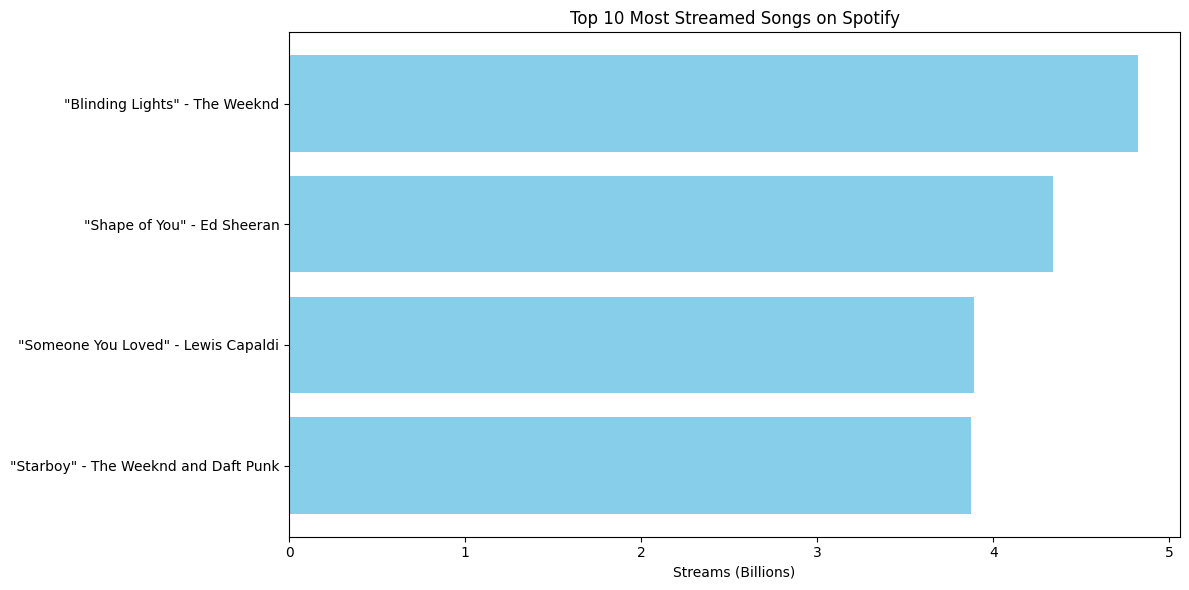

In [7]:
# Step 2: Download HTML
url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"
try:
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for bad status codes
    html_content = response.text
except requests.exceptions.RequestException as e:
    print(f"Error fetching URL: {e}")
    exit()

# Step 3: Transform HTML using BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')
tables = soup.find_all('table', {'class': 'wikitable'})

if not tables:
    print("Error: No wikitable found on the page.")
    exit()

# Convert the first table to string and read with pandas
table_str = str(tables[0])
try:
    tables = pd.read_html(StringIO(table_str))
    spotify_table = tables[0]
except ValueError as e:
    print(f"Error reading HTML table: {e}")
    print(f"Problematic HTML content:\n{table_str}")  # Print the HTML that caused the error
    exit()

# Step 4: Process the DataFrame
# Clean column names
spotify_table.columns = ['Rank', 'Song', 'Artist', 'Streams', 'ReleaseYear', 'Date']

# Remove notes and citations from song and artist names
spotify_table['Song'] = spotify_table['Song'].str.replace(r'\[.*\]', '', regex=True)
spotify_table['Artist'] = spotify_table['Artist'].str.replace(r'\[.*\]', '', regex=True)

# Clean streams column
# Iterate through columns to find the one containing 'billion'
for col in spotify_table.columns:
    if spotify_table[col].dtype == 'object' and spotify_table[col].str.contains('billion').any():
        spotify_table['Streams'] = spotify_table[col].str.replace(' billion', '', regex=True)
        spotify_table['Streams'] = spotify_table['Streams'].str.replace(r'\[\d+\]', '', regex=True)  # remove citation
        
        # Remove any non-numeric characters (except for '.')
        spotify_table['Streams'] = spotify_table['Streams'].str.replace(r'[^\d\.]', '', regex=True)

        # Try converting to numeric, store errors, and show problematic values.
        spotify_table['Streams'] = pd.to_numeric(spotify_table['Streams'], errors='coerce')
        
        # Print problematic non-numeric values
        non_numeric_streams = spotify_table[pd.isna(spotify_table['Streams'])]
        if len(non_numeric_streams) > 0:
            print("Non-numeric values found in 'Streams' column:")
            print(non_numeric_streams)
            print(f"Problematic values: {non_numeric_streams['Streams'].tolist()}") # Print the list of values

        spotify_table.dropna(subset=['Streams'], inplace=True)  # Drop rows where conversion failed
        break

# Add scraping date
spotify_table['ScrapingDate'] = datetime.now().date()

# Step 5: Store in SQLite
conn = sqlite3.connect('spotify_streams.db')
cursor = conn.cursor()

try:
    # Create table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS most_streamed_songs (
        rank INTEGER,
        song TEXT,
        artist TEXT,
        streams REAL,
        release_year INTEGER,
        date TEXT,
        scraping_date TEXT
    )
    ''')

    # Insert data into the table
    for _, row in spotify_table.iterrows():
        cursor.execute('''
        INSERT INTO most_streamed_songs VALUES (?, ?, ?, ?, ?, ?, ?)
        ''', (row['Rank'], row['Song'], row['Artist'], row['Streams'], row['ReleaseYear'], row['Date'], row['ScrapingDate']))

    conn.commit()
    print("Data successfully scraped and stored in database!")

except sqlite3.Error as e:
    print(f"Error interacting with database: {e}")
    conn.rollback()  # Rollback changes on error
finally:
    conn.close()

# Step 6: Visualizations
# Load data back from SQLite for visualization
conn = sqlite3.connect('spotify_streams.db')
try:
    df = pd.read_sql_query("SELECT * FROM most_streamed_songs", conn)
except sqlite3.Error as e:
    print(f"Error reading from database: {e}")
    conn.close()
    exit()
conn.close()

# Visualization 1: Top 10 Most Streamed Songs
plt.figure(figsize=(12, 6))
# Sort the DataFrame by streams *before* selecting the top 10
try:
    # Check the data type of the 'Streams' column *before* sorting
    print(f"Data type of 'Streams' column before sorting: {df['streams'].dtype}")

    # Check if there are any non-numeric values *before* sorting
    non_numeric_values = df[pd.to_numeric(df['streams'], errors='coerce').isna()]
    if len(non_numeric_values) > 0:
        print("Non-numeric values in 'streams' column:")
        print(non_numeric_values)

    # Convert 'Streams' to numeric *before* sorting.  This is the key fix.
    df['streams'] = pd.to_numeric(df['streams'], errors='coerce')
    df.dropna(subset=['streams'], inplace=True)  # Drop any rows that failed to convert

    # Check again the data type of the 'Streams' column
    print(f"Data type of 'streams' column after conversion: {df['streams'].dtype}")

    top_10 = df.sort_values(by='streams', ascending=False).head(10)
    plt.barh(top_10['song'] + ' - ' + top_10['artist'], top_10['streams'], color='skyblue')
    plt.xlabel('Streams (Billions)')
    plt.title('Top 10 Most Streamed Songs on Spotify')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('top10_songs.png')
    plt.show()
except Exception as e:
    print(f"Error during visualization: {e}")
    print(df.dtypes)  # Print the datatypes of the dataframe.
    print(df.head())